In [1]:
!pip install google-cloud-bigquery google-cloud-bigquery-storage --upgrade

In [1]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True) 


{'status': 'ok', 'restart': True}

### Configure GCP environment settings

Update the following variables to reflect the values for your GCP environment:

* PROJECT_ID: The ID of the Google Cloud project you are using to implement this solution.
* REGION: The region to use for the BigQuery dataset.

In [1]:
PROJECT_ID = 'galvanic-portal-404814' # Change to your project.
REGION = 'US'

In [4]:
from google.cloud import bigquery
import pandas as pd
from datetime import datetime, timedelta

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_historical_and_forecast(input_timeseries, 
                                 timestamp_col_name, 
                                 data_col_name, 
                                 forecast_output=None, 
                                 actual=None, 
                                 title=None,
                                 plotstartdate=None):

    if plotstartdate:
        input_timeseries[timestamp_col_name] = pd.to_datetime(input_timeseries[timestamp_col_name])
        input_timeseries = input_timeseries[input_timeseries[timestamp_col_name] >= pd.to_datetime(plotstartdate)]
        
    input_timeseries = input_timeseries.sort_values(timestamp_col_name)    
    
    # Plot the input historical data
    plt.figure(figsize=(20,6))
    plt.plot(input_timeseries[timestamp_col_name], input_timeseries[data_col_name], label = 'Historical')
    plt.xlabel(timestamp_col_name)
    plt.ylabel(data_col_name)

    if forecast_output is not None:
        forecast_output = forecast_output.sort_values('forecast_timestamp')
        forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
        x_data = forecast_output['forecast_timestamp']
        y_data = forecast_output['forecast_value']
        confidence_level = forecast_output['confidence_level'].iloc[0] * 100
        low_CI = forecast_output['confidence_interval_lower_bound']
        upper_CI = forecast_output['confidence_interval_upper_bound']
        # Plot the forecast data
        plt.plot(x_data, y_data, alpha = 1, label = 'Forecast', linestyle='--')
        # Shade the confidence interval
        plt.fill_between(x_data, low_CI, upper_CI, color = '#539caf', alpha = 0.4, 
                         label = f'{confidence_level} confidence interval')

    # Plot actual data
    if actual is not None:
        actual = actual.sort_values(timestamp_col_name)
        plt.plot(actual[timestamp_col_name], actual[data_col_name], label = 'Actual', linestyle='--')   

    # Display title, legend
    plt.title(f'{title}', fontsize= 16)
    plt.legend(loc = 'upper center', prop={'size': 16})

### Create a BigQuery dataset

In [15]:
!bq mk --location=$REGION --dataset $PROJECT_ID:retailforecast

Dataset 'galvanic-portal-404814:retailforecast' successfully created.


In [6]:
%%bigquery --project $PROJECT_ID

SELECT product_name, product_id,product_category,
       SUM(CASE WHEN sold_at IS NOT NULL THEN product_retail_price ELSE 0 END) AS sales 
FROM `bigquery-public-data.thelook_ecommerce.inventory_items` 
GROUP BY product_id,product_name ,product_category
ORDER BY sales desc
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,product_name,product_id,product_category,sales
0,Jordan Low Quarter Sock Style # 427411,25348,Socks,10836.000
1,Darla,24447,Outerwear & Coats,9990.000
2,Catherine Malandrino Women's Skinny Stretch Le...,5213,Pants & Capris,9845.000
3,Canada Goose Women's Expedition Parka,8300,Outerwear & Coats,9540.000
4,The North Face Apex Bionic Mens Soft Shell Ski...,24428,Outerwear & Coats,9030.000


### Training dataset preparation

##### At first, we intend to do the sales forecast for specific products in each category. For example, in Hoodies and Sweater category, which are the best sellers from Adidas, Nike or Canada Goose, etc. However, the sales for each products is not really significant on a daily basis, we decided to do the prediction by top 5 best selling categories.

In [7]:
%%bigquery --project $PROJECT_ID
with topsellingitems AS
(
SELECT product_name, product_id,product_category,
       SUM(CASE WHEN sold_at IS NOT NULL THEN product_retail_price ELSE 0 END) AS sales 
FROM `bigquery-public-data.thelook_ecommerce.inventory_items` 
GROUP BY product_id,product_name ,product_category
ORDER BY sales desc
LIMIT 5)
SELECT 
     CAST(sold_at AS DATE) AS sold_date,
    product_name, 
    product_id,
    product_category,
    SUM(CASE WHEN sold_at IS NOT NULL THEN product_retail_price ELSE 0 END) AS sales 
FROM `bigquery-public-data.thelook_ecommerce.inventory_items` 
where product_id in (select product_id from topsellingitems) 
and sold_at is not null
GROUP BY 
    sold_date, 
    product_id, 
    product_name, 
    product_category

Query is running:   0%|          |

Downloading:   0%|          |

,sold_date,product_name,product_id,product_category,sales
0,2022-04-13,Jordan Low Quarter Sock Style # 427411,25348,Socks,903.000
1,2023-11-19,Jordan Low Quarter Sock Style # 427411,25348,Socks,903.000
2,2023-10-08,Jordan Low Quarter Sock Style # 427411,25348,Socks,903.000
3,2023-05-09,Jordan Low Quarter Sock Style # 427411,25348,Socks,903.000
4,2023-02-16,Jordan Low Quarter Sock Style # 427411,25348,Socks,903.000
5,2022-05-01,Jordan Low Quarter Sock Style # 427411,25348,Socks,903.000
6,2023-04-03,Jordan Low Quarter Sock Style # 427411,25348,Socks,903.000
7,2023-07-01,Jordan Low Quarter Sock Style # 427411,25348,Socks,903.000
8,2023-09-04,Jordan Low Quarter Sock Style # 427411,25348,Socks,903.000
9,2023-08-29,Jordan Low Quarter Sock Style # 427411,25348,Socks,903.000


In [27]:
%%bigquery --project $PROJECT_ID
with topsellingitems AS
(
SELECT product_category,
       SUM(CASE WHEN sold_at IS NOT NULL THEN product_retail_price ELSE 0 END) AS sales 
FROM `bigquery-public-data.thelook_ecommerce.inventory_items` 
GROUP BY  product_category
ORDER BY sales desc
LIMIT 5)
SELECT 
  CAST(sold_at AS DATE) AS sold_date,
    product_category,
    SUM(CASE WHEN sold_at IS NOT NULL THEN product_retail_price ELSE 0 END) AS sales 
FROM `bigquery-public-data.thelook_ecommerce.inventory_items` 
where product_category in (select product_category from topsellingitems) 
and sold_at is not null
GROUP BY 
    sold_date, 
    product_category

Query is running:   0%|          |

Downloading:   0%|          |

,sold_date,product_category,sales
0,2022-07-11,Fashion Hoodies & Sweatshirts,452.800
1,2023-10-22,Fashion Hoodies & Sweatshirts,1117.610
2,2021-11-30,Fashion Hoodies & Sweatshirts,519.890
3,2022-09-29,Fashion Hoodies & Sweatshirts,702.330
4,2020-01-21,Fashion Hoodies & Sweatshirts,45.950
...,...,...,...
7669,2019-06-02,Sweaters,33.990
7670,2019-11-12,Sweaters,33.990
7671,2019-11-17,Jeans,194.000
7672,2019-12-08,Outerwear & Coats,229.000


In [8]:
%%bigquery --project $PROJECT_ID
select * from retailforecast.training_data a1
join (
select product_category, max(sales) sales from retailforecast.training_data
group by product_category
) a2 on a1.product_category = a2.product_category and a1.sales = a2.sales


Query is running:   0%|          |

Downloading:   0%|          |

,sold_date,product_category,sales,product_category_1,sales_1
0,2022-12-17,Swim,1153.830,Swim,1153.830
1,2022-12-02,Jeans,2354.100,Jeans,2354.100
2,2022-12-01,Sweaters,1462.430,Sweaters,1462.430
3,2022-12-17,Outerwear & Coats,3068.640,Outerwear & Coats,3068.640
4,2022-04-03,Fashion Hoodies & Sweatshirts,1462.840,Fashion Hoodies & Sweatshirts,1462.840


#### Top 5 product category we should focus forecasting for next period are:
1. Swim
2. Jeans
3. Sweaters
4. Outerwear & Coats
5. Fashion Hoodies & Sweatshirts

### Set the training period dataset 

In [9]:
ARIMA_PARAMS_RETAIL = {
    'TRAININGDATA_STARTDATE': '2021-06-01',
    'TRAININGDATA_ENDDATE': '2023-01-01',
}
ARIMA_PARAMS_RETAIL

{'TRAININGDATA_STARTDATE': '2021-06-01', 'TRAININGDATA_ENDDATE': '2023-01-01'}

### Create training table data under project 

In this step, we utilize BigQuery to get understanding of data structure and pre-process data with missing valuesl. We have not done the anamolies detection for the sake of simplicity and it could be the further deployment of the model in real business context

In [10]:
%%bigquery --params $ARIMA_PARAMS_RETAIL  --project $PROJECT_ID 

CREATE OR REPLACE TABLE retailforecast.training_data AS (
with topsellingitems AS
(
SELECT product_category,
       SUM(CASE WHEN sold_at IS NOT NULL THEN product_retail_price ELSE 0 END) AS sales 
FROM `bigquery-public-data.thelook_ecommerce.inventory_items` 
GROUP BY  product_category
ORDER BY sales desc
LIMIT 5)
SELECT 
    CAST(sold_at AS DATE) AS sold_date,
    product_category,
    SUM(CASE WHEN sold_at IS NOT NULL THEN product_retail_price ELSE 0 END) AS sales 
FROM `bigquery-public-data.thelook_ecommerce.inventory_items` 
where product_category in (select product_category from topsellingitems) 
and sold_at between @TRAININGDATA_STARTDATE and @TRAININGDATA_ENDDATE
and sold_at is not null
GROUP BY 
    sold_date, 
    product_category)
;
select * from retailforecast.training_data
limit 5

Query is running:   0%|          |

Downloading:   0%|          |

,sold_date,product_category,sales
0,2022-08-22,Swim,938.010
1,2022-03-02,Swim,195.890
2,2021-09-23,Swim,363.180
3,2022-06-17,Swim,224.850
4,2022-10-01,Swim,503.730


In [12]:
%%bigquery retailhist --project $PROJECT_ID 

SELECT 
    * 
FROM 
    retailforecast.training_data

Query is running:   0%|          |

Downloading:   0%|          |

### Historical sales trend for top 5 product category

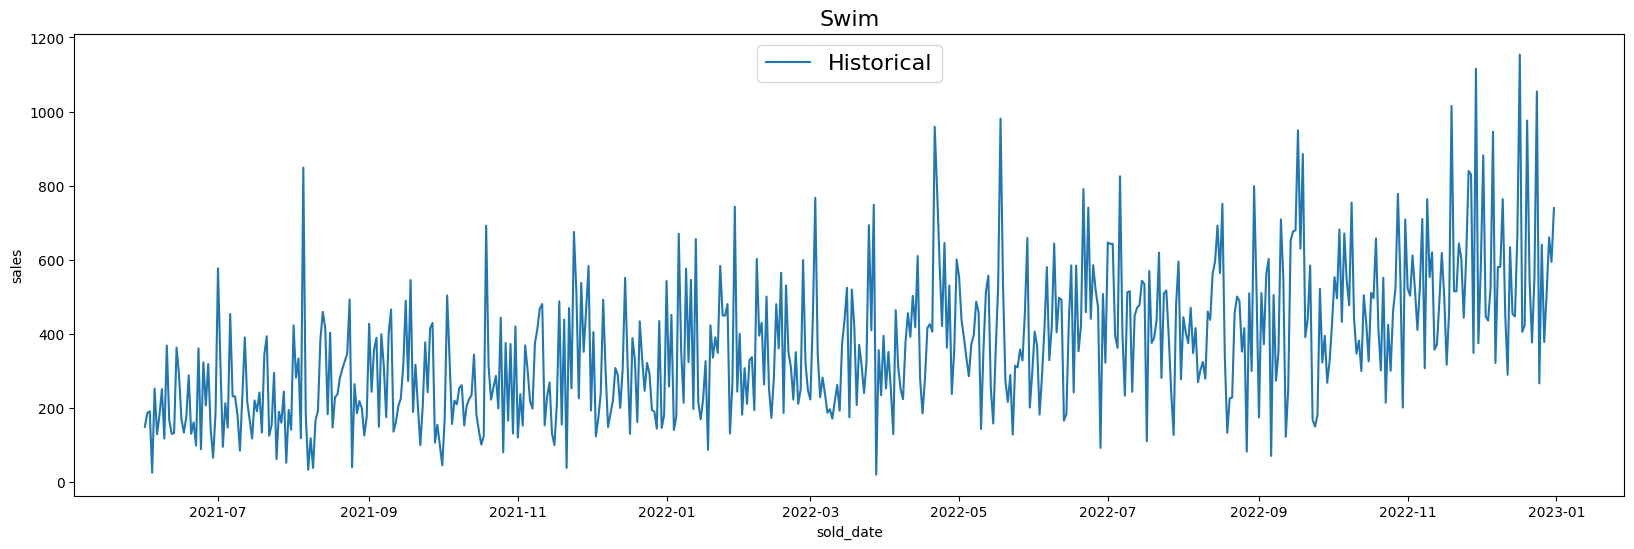

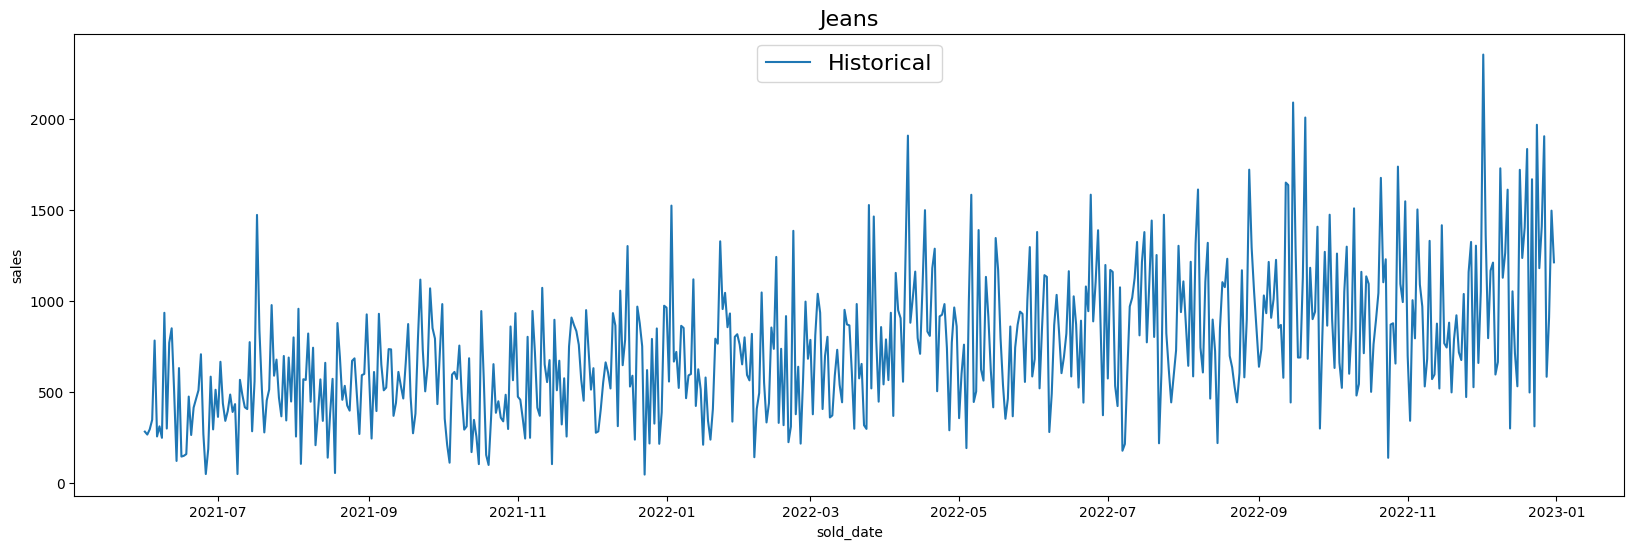

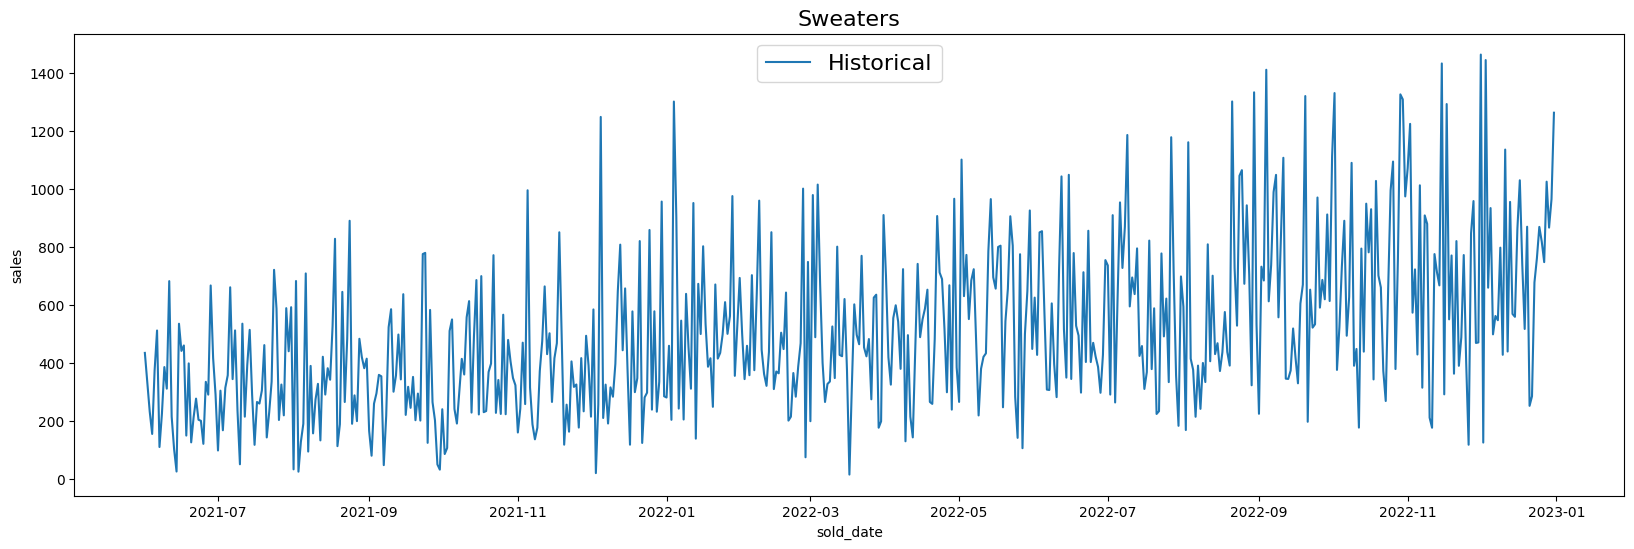

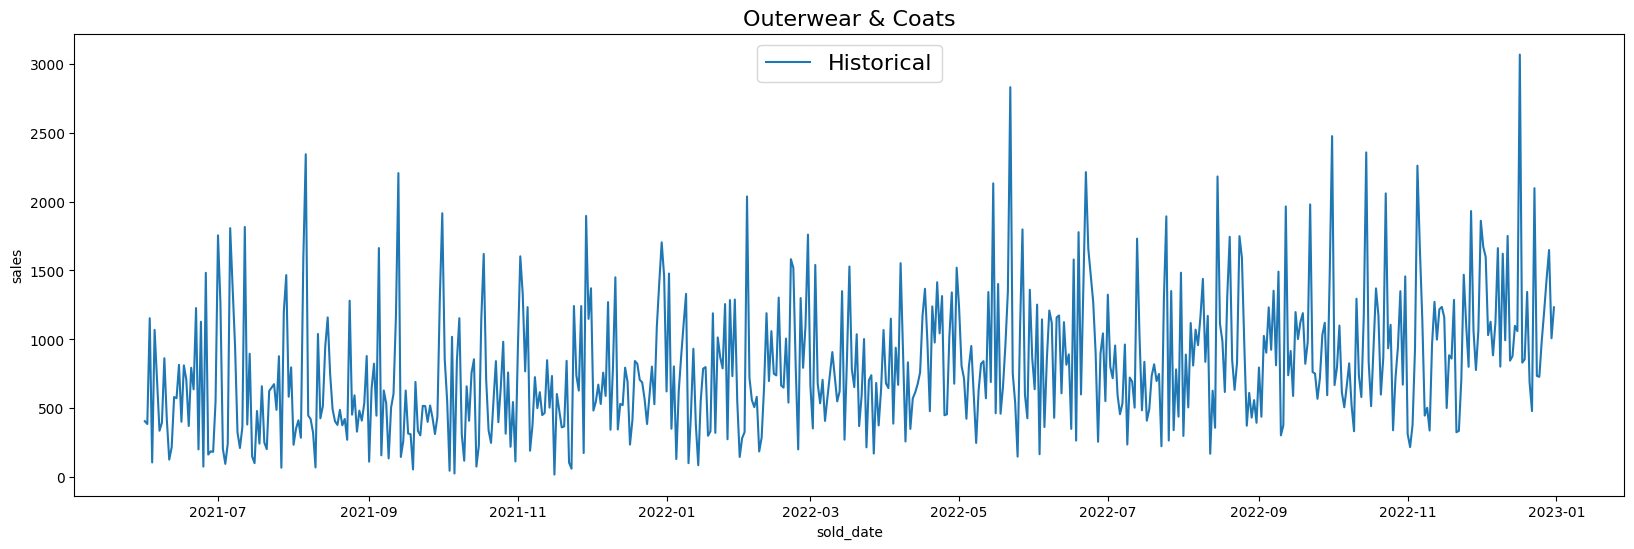

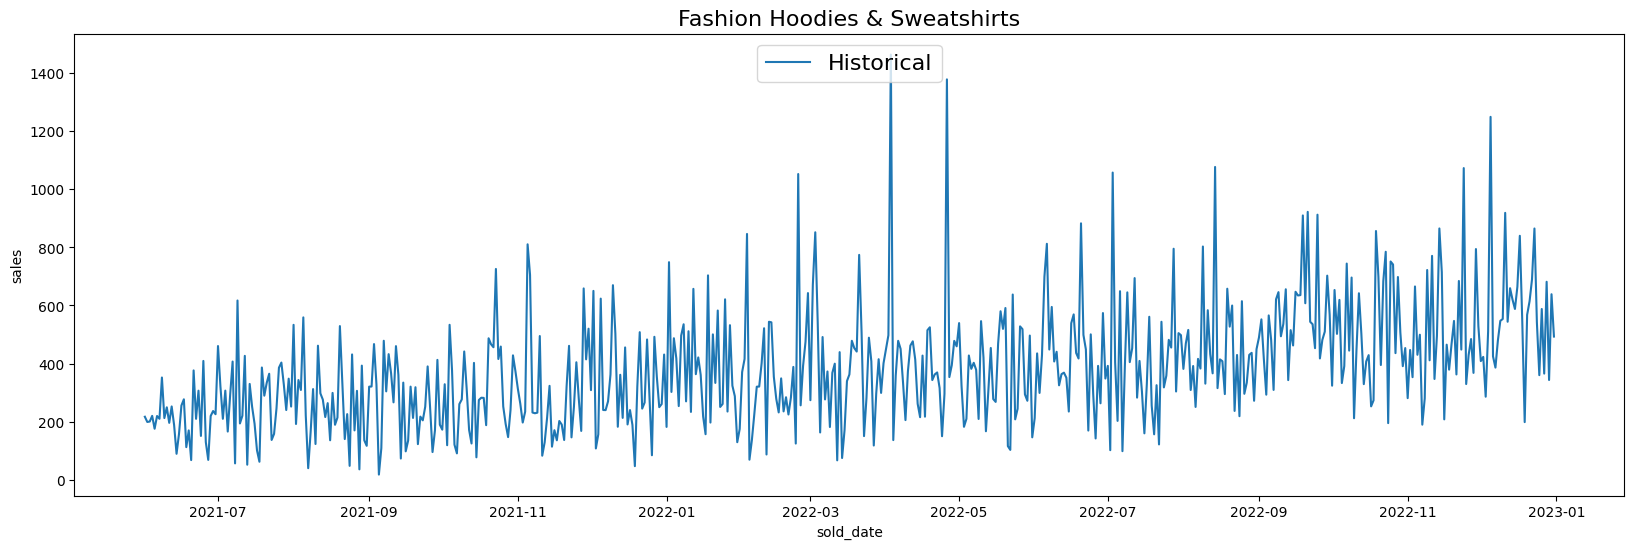

In [61]:
itemslist_retail = list(retailhist.product_category.unique())

for item in itemslist_retail:
    
    datah = retailhist[retailhist.product_category==item]
    plot_historical_and_forecast(input_timeseries = datah, 
                                 timestamp_col_name = "sold_date", 
                                 data_col_name = "sales", 
                                 forecast_output = None, 
                                 actual = None,
                                 title = item)

### Start training the model - ARIMA model with holiday variable taken into consideration

In [13]:
%%bigquery --project $PROJECT_ID 

CREATE OR REPLACE MODEL retailforecast.arima_model

OPTIONS(
  MODEL_TYPE='ARIMA',
  TIME_SERIES_TIMESTAMP_COL='sold_date', 
  TIME_SERIES_DATA_COL='sales',
  TIME_SERIES_ID_COL='product_category',
  HOLIDAY_REGION='US'
) AS

SELECT 
    sold_date,
    product_category,
    sales
FROM
  retailforecast.training_data

Query is running:   0%|          |

""


In [14]:

%%bigquery --project $PROJECT_ID 

SELECT
  *
FROM
  ML.EVALUATE(MODEL retailforecast.arima_model)

Query is running:   0%|          |

Downloading:   0%|          |

,product_category,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods
0,Jeans,0,1,5,True,-3974.036,7962.072,53973.337,[WEEKLY]
1,Outerwear & Coats,0,1,5,True,-4158.867,8331.733,101487.337,[WEEKLY]
2,Suits & Sport Coats,3,1,1,True,-3910.349,7832.697,44665.319,[WEEKLY]
3,Sweaters,0,1,5,True,-3799.955,7613.911,29285.728,[WEEKLY]
4,Swim,0,1,5,True,-3622.331,7258.662,16080.276,[WEEKLY]


### Perform the sales forecast for next 3 months with the confidence level at 90

In [16]:
%%bigquery dfforecast_re --project $PROJECT_ID 

DECLARE HORIZON STRING DEFAULT "90"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90";

EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM 
      ML.FORECAST(MODEL retailforecast.arima_model, 
                  STRUCT(%s AS horizon, 
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)

Query is running:   0%|          |

Downloading:   0%|          |

In [65]:
print(f"Number of rows: {dfforecast_re.shape[0]}")

Number of rows: 450


### Visualize the predicted sales vs historical sales trend

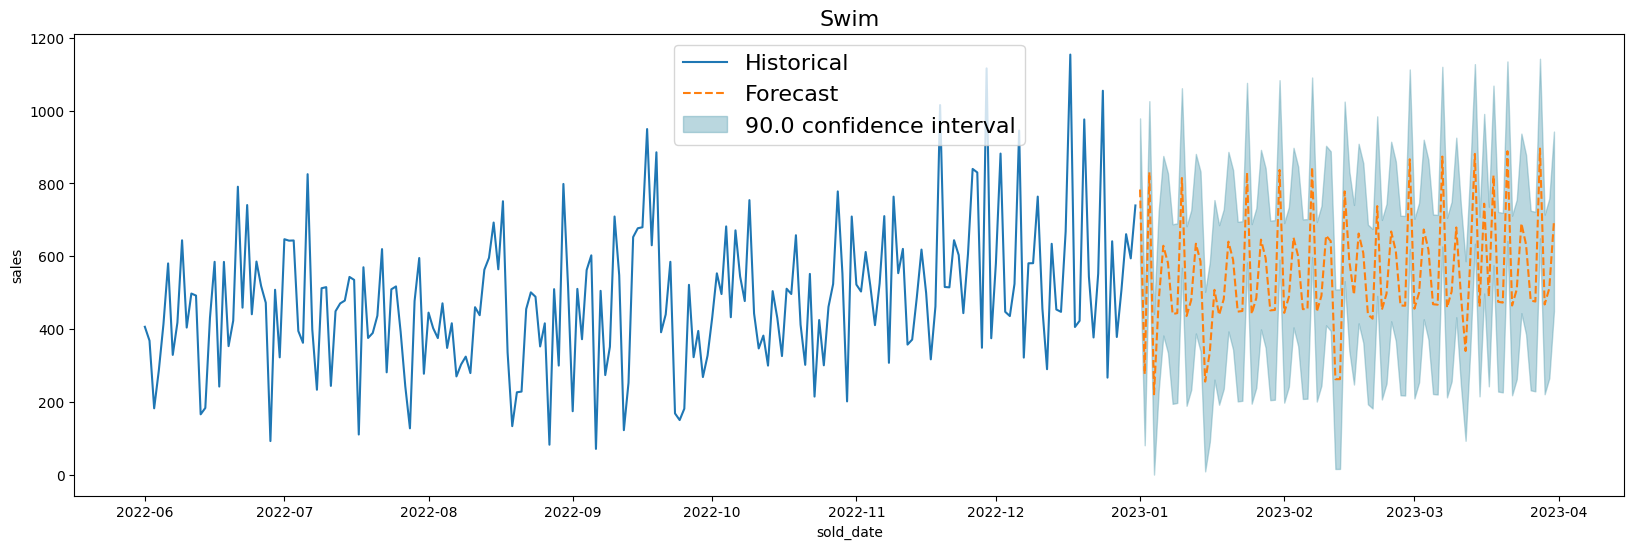

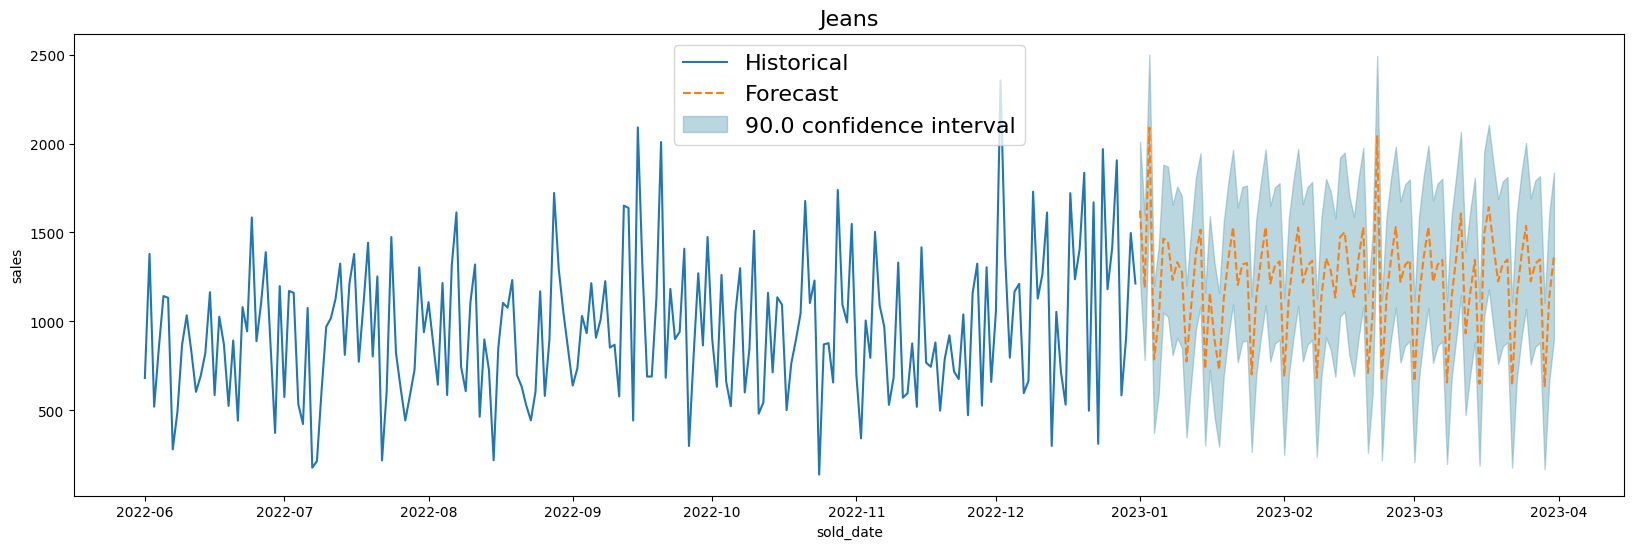

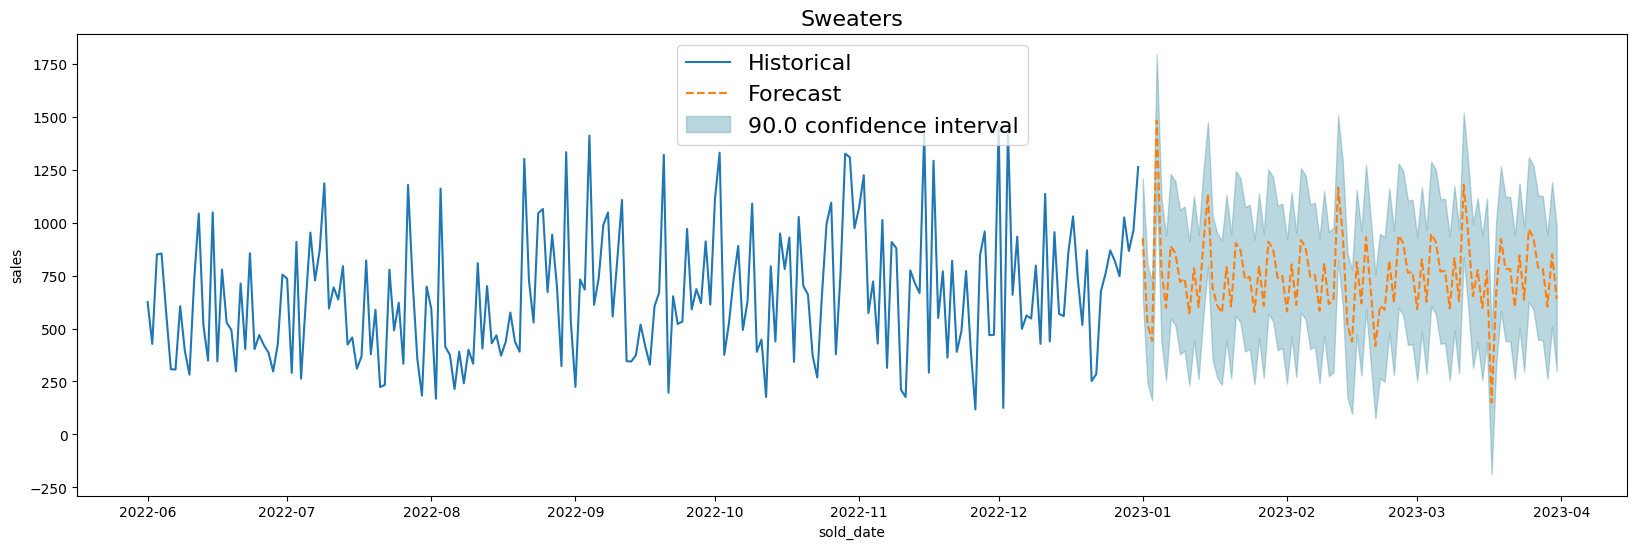

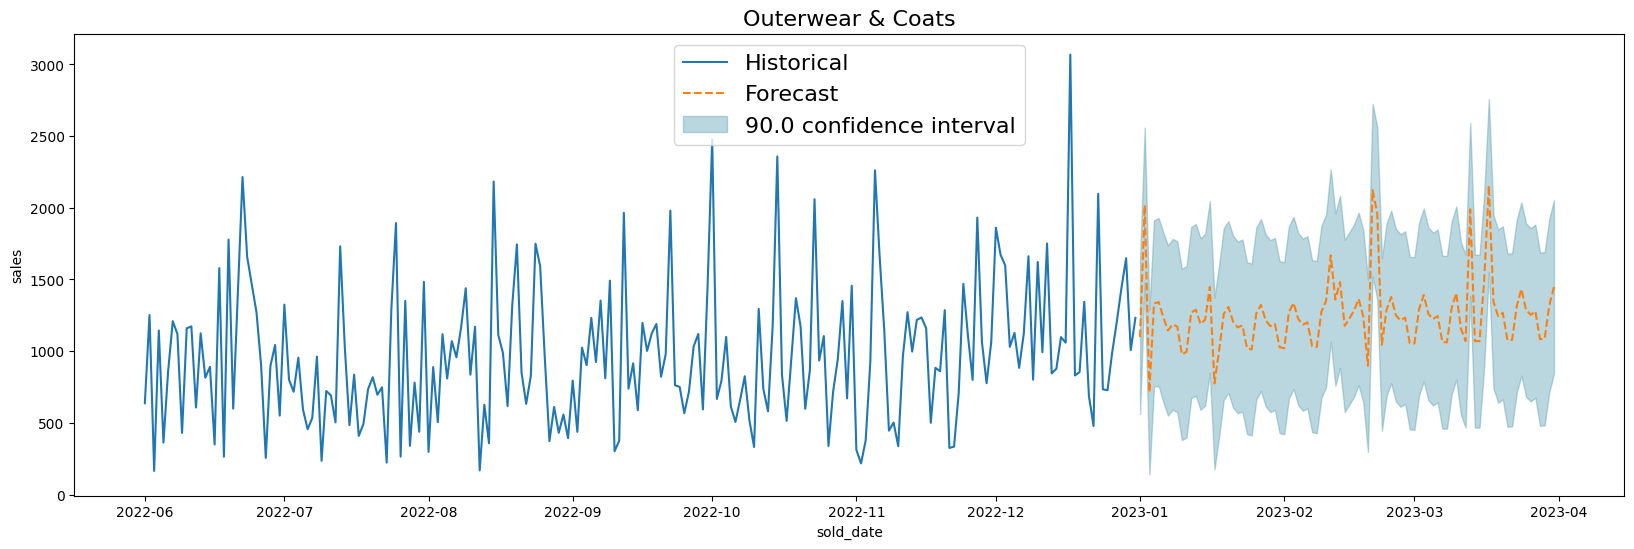

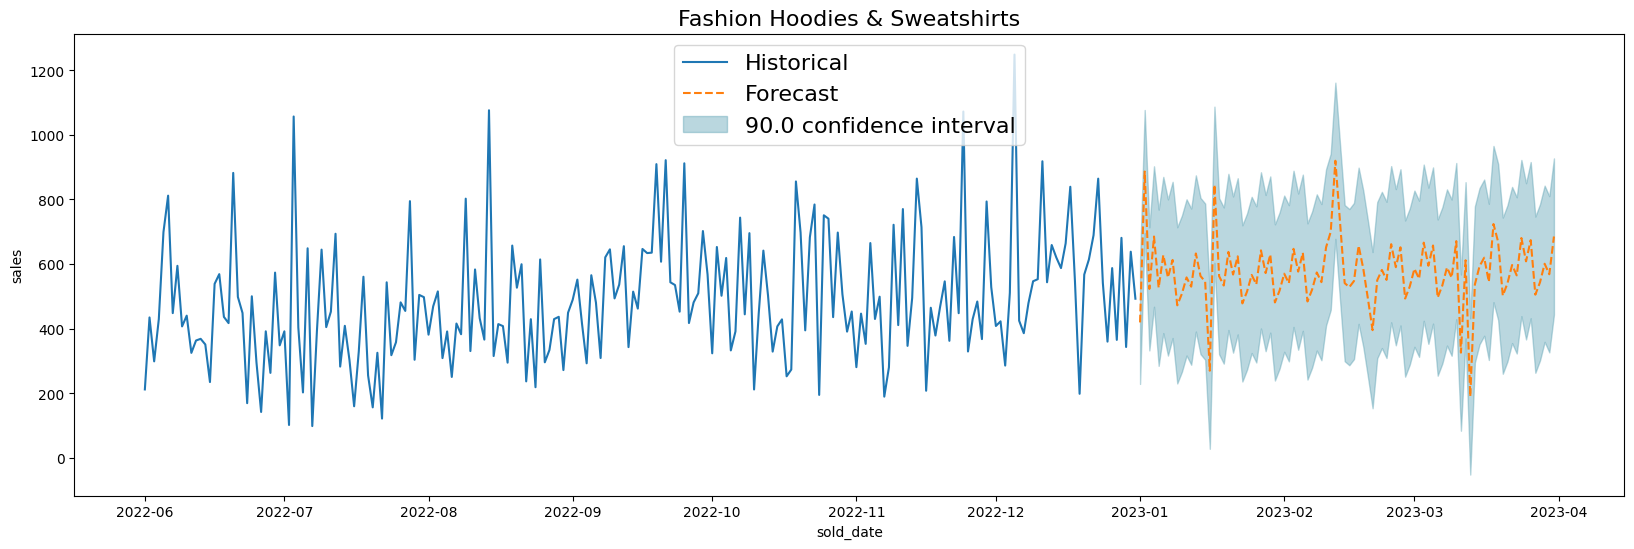

In [68]:
itemslist = list(retailhist.product_category.unique())

for item in itemslist:
    datah = retailhist[retailhist.product_category==item].copy()
    dataf = dfforecast_re[dfforecast_re.product_category==item].copy()
    
    plot_historical_and_forecast(input_timeseries = datah, 
                                 timestamp_col_name = "sold_date", 
                                 data_col_name = "sales", 
                                 forecast_output = dataf, 
                                 actual = None,
                                 title = item,
                                 plotstartdate = "2022-06-01")

### Save the model for future use 

In [17]:
%%bigquery dfactual_re --params $ARIMA_PARAMS_RETAIL --project $PROJECT_ID 

DECLARE HORIZON STRING DEFAULT "90"; #number of values to forecast

SELECT 
    CAST(sold_at AS DATE) AS sold_date,
    product_category,
    SUM(CASE WHEN sold_at IS NOT NULL THEN product_retail_price ELSE 0 END) AS sales 
FROM
    `bigquery-public-data.thelook_ecommerce.inventory_items` 
GROUP BY
    sold_date, 
    product_category
HAVING 
    sold_date BETWEEN DATE_ADD(@TRAININGDATA_ENDDATE, 
                              INTERVAL 1 DAY) 
            AND DATE_ADD(@TRAININGDATA_ENDDATE, 
                             INTERVAL 1+CAST(HORIZON AS INT64) DAY) 
ORDER BY
    sold_date;

Query is running:   0%|          |

Downloading:   0%|          |

In [70]:
dfactual_re.head()

,sold_date,product_category,sales
0,2023-01-02,Fashion Hoodies & Sweatshirts,517.860
1,2023-01-02,Outerwear & Coats,2199.010
2,2023-01-02,Socks,140.930
3,2023-01-02,Shorts,533.140
4,2023-01-02,Pants,384.460


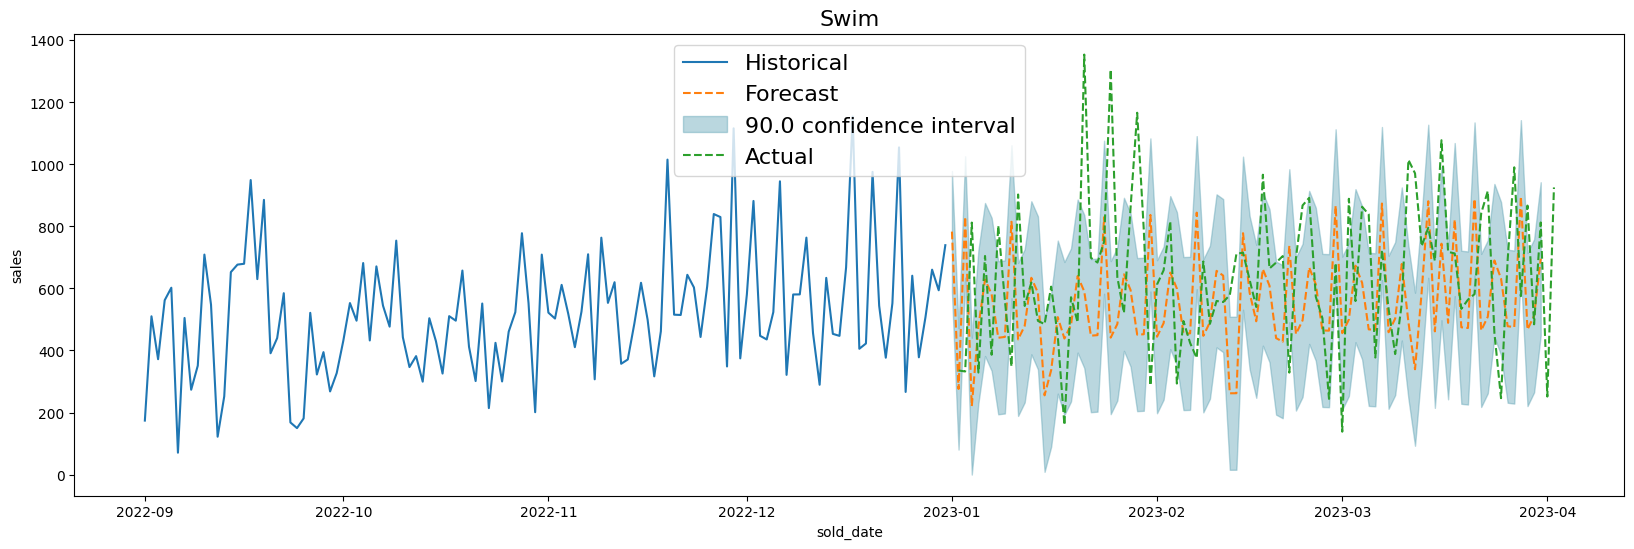

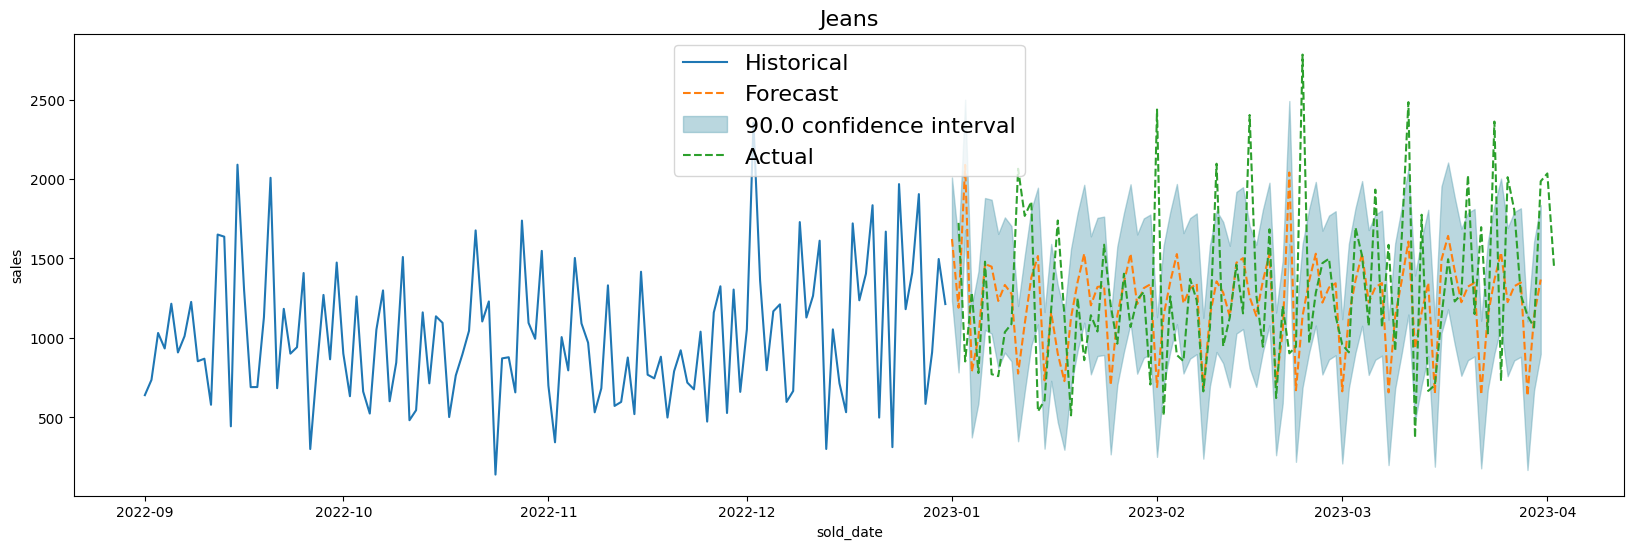

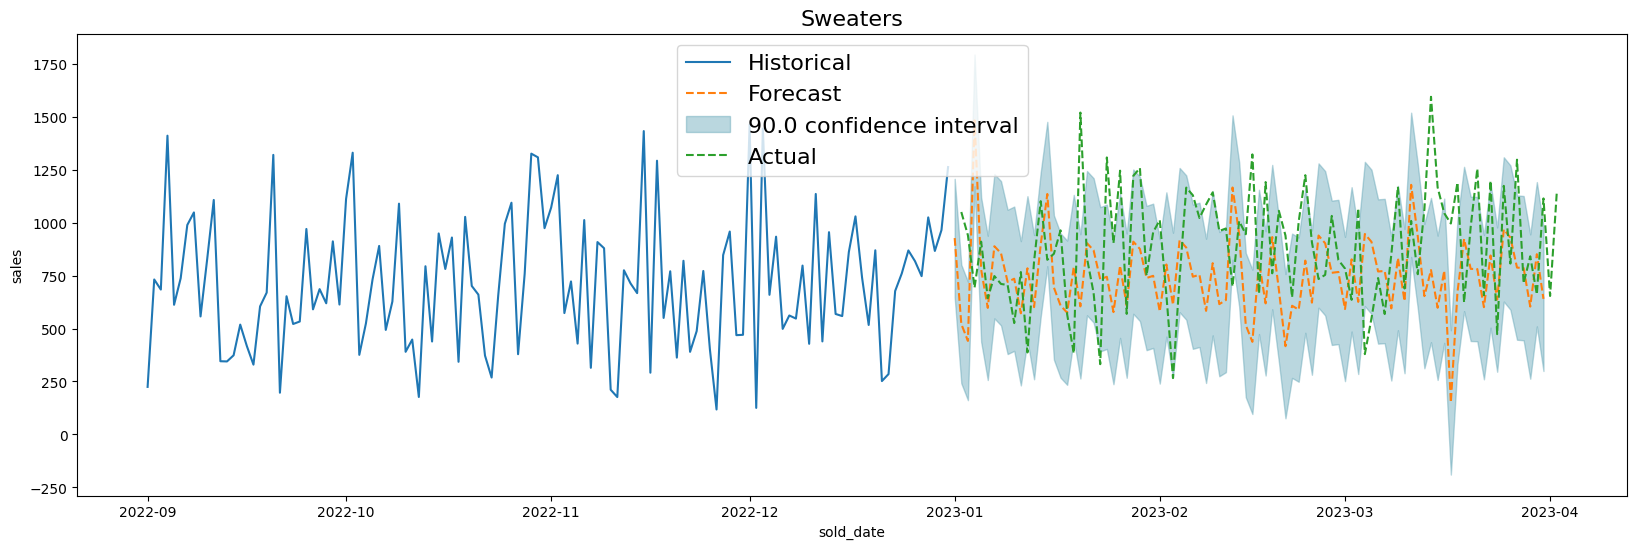

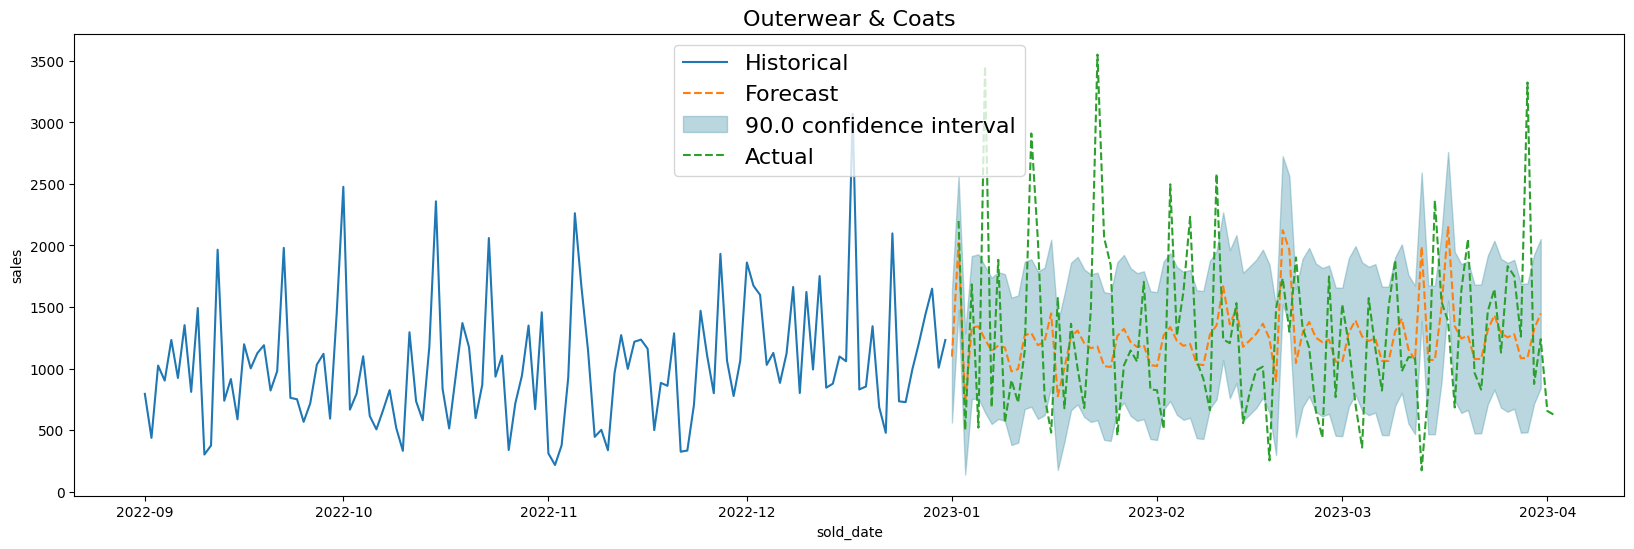

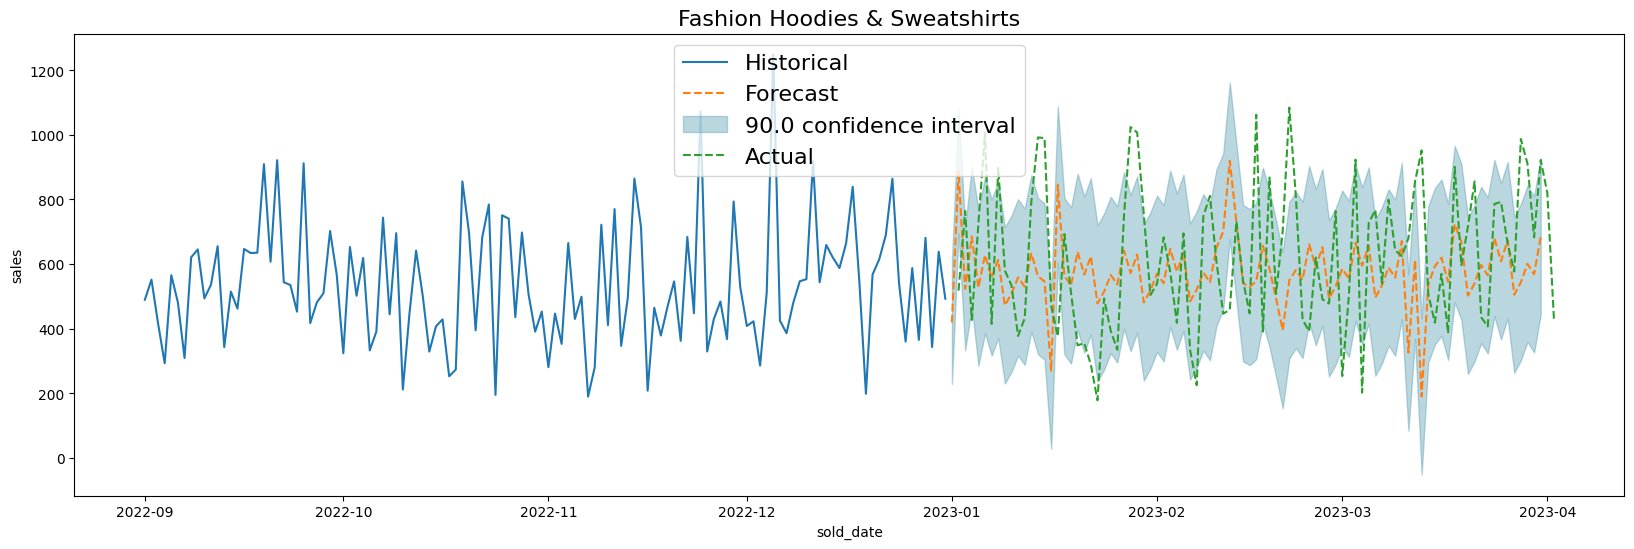

In [73]:
itemslist = list(retailhist.product_category.unique())

for item in itemslist:
    datah = retailhist[retailhist.product_category==item].sort_values('sold_date')
    dataf = dfforecast_re[dfforecast_re.product_category==item].sort_values(['forecast_timestamp'])
    dataa = dfactual_re[dfactual_re.product_category==item].sort_values('sold_date')
    plot_historical_and_forecast(input_timeseries = datah, 
                             timestamp_col_name = "sold_date", 
                             data_col_name = "sales", 
                             forecast_output = dataf, 
                             actual = dataa,
                             title = item,
                             plotstartdate = "2022-09-01")

The charts show predicted sales forecast across products pretty stable in Feb and Mar 2023, which is within 90% confidence level, the fluctuation happened significantly in **Outerwear coats** in Jan, this maybe due to seasonal factor regarding the behavior during winter in specific region which is also need to be taken into consideration 

### Suggestion for further deployment
1. Adding lagging and rolling features to the model for each training window
2. Considering using advanced models like XGBoost or LightGBM 
3. Adding insightful features like Top 25 Rising queries from **Google Trends** <td>
      <a href="https://console.cloud.google.com/marketplace/product/bigquery-public-datasets/google-search-trends?_ga=2.261190030.2019434361.1656948847-1975246695.1656948843&project=galvanic-portal-404814">
        <img src="https://i.ibb.co/RhC6V4R/googletrends-81-1-1.png" alt="">dataset Google trends on Google BigQuery </a>
    </td>

In [18]:
%%bigquery --params $ARIMA_PARAMS_RETAIL  --project $PROJECT_ID 

CREATE OR REPLACE TABLE retailforecast.outputdata_datastudio AS (
  SELECT
    sold_date AS timestamp,
    product_category,
    sales AS history_value,
    NULL AS forecast_value,
    NULL AS prediction_interval_lower_bound,
    NULL AS prediction_interval_upper_bound
  FROM
    retailforecast.training_data
  UNION ALL
  SELECT
    EXTRACT(DATE
    FROM
      forecast_timestamp) AS timestamp,
    product_category,
    NULL AS history_value,
    forecast_value,
    prediction_interval_lower_bound,
    prediction_interval_upper_bound
  FROM
    ML.FORECAST(MODEL retailforecast.arima_model,
      STRUCT(90 AS horizon, 0.9 AS confidence_level)) 
  ORDER BY timestamp
  )

Query is running:   0%|          |

""
